## Summary

In this work, we present <b>fastMONAI</b>, a low-code Python-based open source deep learning library built on top of fastai [@howard2020fastai; @howard2020deep], MONAI [@monai], and TorchIO [@perez2021torchio]. We created the library to simplify the use of state-of-the-art deep learning techniques in 3D medical image analysis for solving classification, regression, and segmentation tasks. fastMONAI provides the users with functionalities to step through data loading, preprocessing, training, and result interpretations. Note that the PDF version of our paper is automatically generated from Jupyter Notebook available in the fastMONAI GitHub repo: [https://github.com/MMIV-ML/fastMONAI](https://github.com/MMIV-ML/fastMONAI). Using the notebook, you can step through all the content, reproducing the below computations.  

## Statement of need 

The pace of developments in deep learning is incredibly fast, with new models, techniques, and tricks constantly appearing. As a result, it is easy to get stuck on something less-than-optimal when using deep learning to solve a particular set of problems while also being in danger of getting lost in minor technical details when constructing models for concrete tasks. The fastai deep learning library [@howard2020fastai; @howard2020deep] provides both a high-level API that automatically incorporates many established best practices and a low-level API in which one can modify details related to model architectures, training strategies, data augmentation, and more. 

fastai is a general deep learning library built on top of PyTorch. Healthcare imaging has a variety of domain-specific demands, including medical imaging formats, data storage and transfer, data labeling procedures, domain-specific data augmentation, and evaluation methods. Project MONAI [@monai] and TorchIO [@perez2021torchio] target deep learning in healthcare imaging, incorporating multiple best practices. 

Our combination of fastai, MONAI, and TorchIO into fastMONAI makes it possible to easily construct, use and train powerful models for a range of medical imaging tasks, using all the best practices and domain-specific features incorporated into these three libraries.

fastMONAI can ease the entry of new practitioners into medical AI and make it possible to quickly construct good baseline models that can be further optimized by going deeper into the underlying libraries. 

## The software: PyTorch, fastai, MONAI, and torchIO

![](paper_files/diagram.png)
<br>
<b> Figure 1: </b> Overview of the components in fastMONAI and their connections to underlying libraries. 

## Example usage

In this section, we will explore how to use our library. We'll look at a simple classification task based on brain MRI. In fastMONAI's online documentation, multiple tutorials cover different classification, regression, and segmentation tasks. 

The following line imports all of the functions and classes from the fastMONAI library: 

In [1]:
from fastMONAI.vision_all import *

### Download external data

For this task, we will download the T1-weighted brain images of healthy subjects (n=556) from the IXI dataset ([https://brain-development.org/ixi-dataset](https://brain-development.org/ixi-dataset)) with the corresponding metadata.
We will download the data with the following line of code. Note that the data set is ~ 4.5G, and the download may take some time. 

In [2]:
path = Path('../data')

In [3]:
STUDY_DIR = download_ixi_data(path=path)

2022-08-31 21:36:54,085 - INFO - Expected md5 is None, skip md5 check for file ../data/IXI/IXI-T1.tar.
2022-08-31 21:36:54,087 - INFO - File exists: ../data/IXI/IXI-T1.tar, skipped downloading.
2022-08-31 21:36:54,089 - INFO - Writing into directory: ../data/IXI/T1_images.
2022-08-31 21:36:56,899 - INFO - Expected md5 is None, skip md5 check for file ../data/IXI/IXI.xls.
2022-08-31 21:36:56,900 - INFO - File exists: ../data/IXI/IXI.xls, skipped downloading.
Preprocessing ../data/IXI/IXI.xls


### Inspect the data

Let's look at how the processed DataFrame is formatted:

In [4]:
df = pd.read_csv(STUDY_DIR/'dataset.csv')

In [5]:
df.head(2)
#print(df.head().to_markdown(2))

,t1_path,subject_id,gender,age_at_scan
0,../data/IXI/T1_images/IXI002-Guys-0828-T1.nii.gz,IXI002,F,35.80
1,../data/IXI/T1_images/IXI012-HH-1211-T1.nii.gz,IXI012,M,38.78


Before feeding the data into a model, we must create a `DataLoaders` object for our dataset. There are several ways to get the data in `DataLoaders`. 
In the following line, we call the ` ImageDataLoaders.from_df` factory method, which is the most basic way of building a `DataLoaders`. 

Here, we pass the processed DataFrame, define the columns for the images `fn_col` and the labels `label_col`, voxel spacing `resample`, some transforms `item_tfms`, and the batch size `bs`. 

In [6]:
dls = MedImageDataLoaders.from_df(df, fn_col='t1_path', 
                                  label_col='gender', 
                                  resample=1, 
                                  item_tfms=[ZNormalization(), PadOrCrop(size=256)], 
                                  bs=4)

We can now take a look at a batch of images in the training set using `show_batch`:

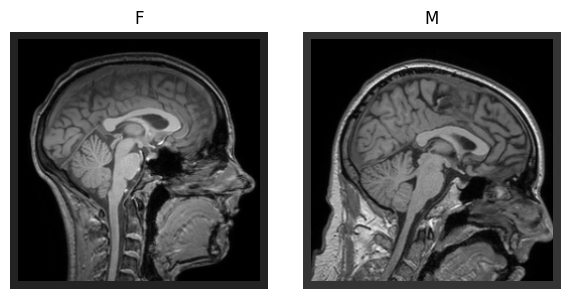

In [7]:
dls.show_batch(max_n=2, anatomical_plane=2)

### Create and train a 3D model 

Next, we import a classification network from MONAI and define the input image size, number of classes to predict, channels, etc.  

In [8]:
from monai.networks.nets import Classifier

model = Classifier(in_shape=[1, 256, 256, 256], classes=2, 
                   channels=(8, 16, 32, 64, 128),strides=(2, 2, 2, 2))

Then we can create a `Learner`, which is a fastai object that combines the data and our defined model for training.

In [9]:
learn = Learner(dls, model, metrics=accuracy)

In [10]:
learn.fit_one_cycle(2) 

epoch,train_loss,valid_loss,accuracy,time
0,7.762875,6.244075,0.776786,01:54
1,2.705631,1.973291,0.866071,01:56


With the model trained, let's look at some predictions on the validation data.

> **Note:** Small random variations are involved in training CNN models. Hence, when running the notebook, you will probably not see exactly the same results shown here.

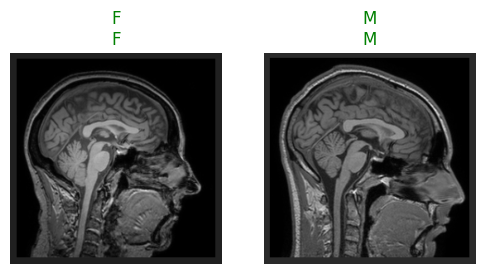

In [11]:
learn.show_results(max_n=2, anatomical_plane=2) 

Showing samples with target value and their corresponding predictions (target|predicition). 

In [12]:
learn.save('model-1')

Path('models/model-1.pth')

### Inference

Let's look at where our trained model becomes confused while making predictions on the validation data:

In [13]:
learn.load('model-1');

In [14]:
interp = ClassificationInterpretation.from_learner(learn)

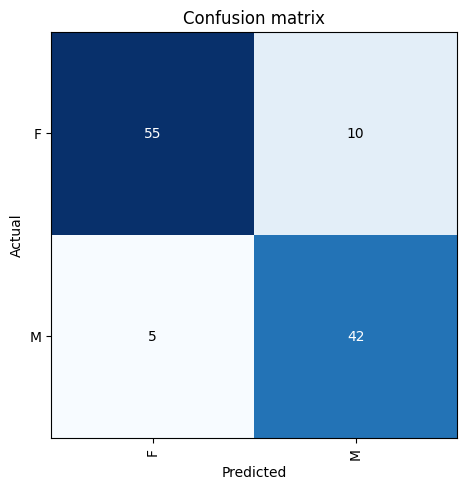

In [15]:
interp.plot_confusion_matrix()

In [16]:
interp.print_classification_report()

              precision    recall  f1-score   support

           F       0.92      0.85      0.88        65
           M       0.81      0.89      0.85        47

    accuracy                           0.87       112
   macro avg       0.86      0.87      0.86       112
weighted avg       0.87      0.87      0.87       112



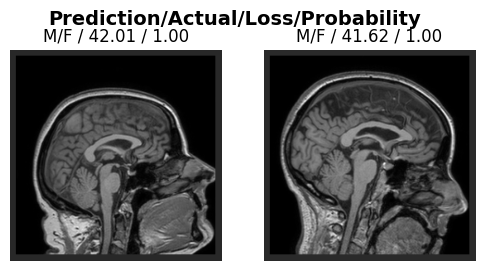

In [17]:
interp.plot_top_losses(k=2, anatomical_plane=2) 

`fastMONAI.vision_all import *` imports the following: 

In [18]:
from fastMONAI.vision_core import *
from fastMONAI.vision_data import *
from fastMONAI.vision_augmentation import *
from fastMONAI.vision_loss import *
from fastMONAI.vision_metrics import * 
from fastMONAI.vision_utils import * 
from fastMONAI.external_data import *
from fastMONAI.dataset_info import *

`MedDataset` is a class to extract and present information about your dataset.

In [19]:
med_dataset = MedDataset(path=STUDY_DIR/'T1_images', max_workers=12)

In [20]:
data_info_df = med_dataset.summary()

In [21]:
data_info_df.head(2)
#print(data_info_df.head().to_markdown(2))

,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,example_path,total
3,256,256,150,0.9375,0.9375,1.2,PSR+,../data/IXI/T1_images/IXI002-Guys-0828-T1.nii.gz,498
2,256,256,146,0.9375,0.9375,1.2,PSR+,../data/IXI/T1_images/IXI035-IOP-0873-T1.nii.gz,74


In [22]:
resample, reorder = med_dataset.suggestion()
resample, reorder

([0.9375, 0.9375, 1.2], False)

Get the largest image size in the dataset after with resampling 

In [23]:
img_size = med_dataset.get_largest_img_size(resample=resample)
img_size

[267.0, 267.0, 150.0]

In [24]:
bs=4
in_shape = [1, 256, 256, 160]

In [25]:
item_tfms = [ZNormalization(), PadOrCrop(in_shape[1:]), 
             RandomAffine(scales=0, degrees=5, isotropic=False)] 

As we mentioned earlier, there are several ways to get the data in `DataLoaders`. In this section, let's rebuild using `DataBlock`. 
Here we need to define what our input and target should be (`MedImage` and `CategoryBlock` for classification), how to get the images and the labels, how to split the data, item transforms that should be applied during training, reorder voxel orientations, and voxel spacing. Take a look at fastai's documentation for DataBlock for further information: [https://docs.fast.ai/data.block.html#DataBlock](https://docs.fast.ai/data.block.html#DataBlock).

In [26]:
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), CategoryBlock), 
                      splitter=RandomSplitter(seed=42),
                      get_x=ColReader('t1_path'),
                      get_y=ColReader('gender'),
                      item_tfms=item_tfms, 
                      reorder=reorder,
                      resample=resample)

Now we pass our processed DataFrame and the batch size to create a `DataLoaders` object. 

In [27]:
dls = dblock.dataloaders(df, bs=bs)

In [28]:
len(dls.train_ds.items), len(dls.valid_ds.items)

(449, 112)

In [29]:
model = Classifier(in_shape=[1, 256, 256, 160], classes=2, 
                   channels=(8, 16, 32, 64, 128),strides=(2, 2, 2, 2),
                   kernel_size=3, num_res_units=2)

In [30]:
learn = Learner(dls, model, metrics=[accuracy])

SuggestedLRs(valley=3.0199516913853586e-05)

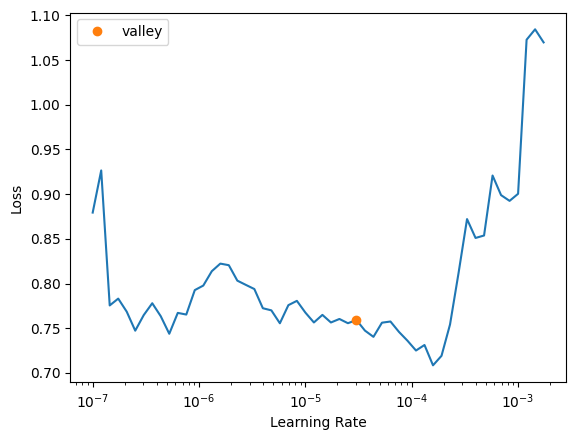

In [31]:
learn.lr_find()

We used the default learning rate before, but we might want to find an optimal value. For this, we can use the learning rate finder. 
Rule of thumb to pick a learning rate: 
- Minimum/10 
- The steepest point(where the loss is clearly decreasing)

In [32]:
lr = 5e-4

In [33]:
learn.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.726082,3.158149,0.732143,01:01
1,2.244310,1.832999,0.803571,01:00
2,1.041343,0.156896,0.955357,01:02
3,0.357789,0.195359,0.937500,01:01


In [34]:
learn.save('model-2')

Path('models/model-2.pth')

### Test-time augmentation

Test-time augmentation (TTA) is a technique where you apply transforms used during traing when making predictions to produce average output.  

In [35]:
learn.load('model-2');

In [36]:
preds, targs = learn.tta() 

In [37]:
accuracy(preds, targs)

TensorBase(0.9286)

## Documentation, usability, and maintainability

We have written the entire fastMONAI library using nbdev, a tool for exploratory programming that allows you to write, test, and document a Python library in Jupyter Notebooks. fastMONAI contains several practical tools to ensure the software's user-friendliness. 

fastMONAI comes with a documentation page ([https://fastmonai.no](https://fastmonai.no)) and step-by-step tutorials on how to use the software for various medical imaging tasks (e.g., classification, regression, and segmentation). Tests are written directly in notebooks, and continuous integration with GitHub Actions runs the tests on each push, making software development easier with multiple collaborators. 

To ease further extensions of our library through contributions, we have added a short guide on how to contribute to the project. As mentioned, this paper is written as a notebook and automatically converted to a markdown file. The latest version is always available on GitHub. 

## Research projects using fastMONAI

The fastMONAI library has been used for skull-stripping from 3D MRI in [@kaliyugarasan20202d], pulmonary nodule classification from CT images in [@kaliyugarasan2021pulmonary], and tumor segmentation in cervical cancer from pelvic MRI in [@hodneland2022fully].

## Acknowledgments

OThe Trond Mohn Research Foundation supported our work through the project “Computational medical imaging and machine learning - methods, infrastructure and applications” at the Mohn Medical Imaging and Visualization Centre, grant number BFS2018TMT07, and a grant from the Western Norway Regional Health Authority (Helse Vest RHF), project F-12532.

## References